In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Functions to load all data: signals, logs and failures

def load_signals() -> pd.DataFrame:
    """Load the signals from the wind farm dataset."""
    df = pd.read_csv('../data/raw/wind-farm-1-signals-2016.csv', sep=';')
    aux = pd.read_csv('../data/raw/wind-farm-1-signals-2017.csv', sep=';')

    df = pd.concat([df, aux], axis=0).reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Turbine_ID'] = df['Turbine_ID'].apply(lambda x: int(x[1:]))
    df = df.sort_values(['Timestamp', 'Turbine_ID']).set_index('Timestamp')
    return df

def load_logs() -> pd.DataFrame:
    """Load the logs from the wind farm dataset."""
    df = pd.read_csv('../data/raw/wind-farm-1-logs-2016.csv', sep=';')
    aux = pd.read_csv('../data/raw/wind-farm-1-logs-2017.csv', sep=';')
    aux.columns = df.columns

    df = pd.concat([df, aux], axis=0).reset_index(drop=True)
    df['TimeDetected'] = pd.to_datetime(df['TimeDetected'])
    df['TimeReset'] = pd.to_datetime(df['TimeReset'],format='mixed', utc=True)
    df['UnitTitle'] = df['UnitTitle'].apply(lambda x: int(x[1:]))
    return df[df.TimeDetected.notna()]

def load_failures() -> pd.DataFrame:
    """Load the failures from the wind farm dataset."""
    df = pd.read_csv('../data/raw/htw-failures-2016.csv', sep=';')
    aux = pd.read_csv('../data/raw/htw-failures-2017.csv', sep=';')

    df = pd.concat([df, aux], axis=0).reset_index(drop=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.set_index('Timestamp').sort_index()
    df = df[df.Turbine_ID != 'T09']
    df['Turbine_ID'] = df['Turbine_ID'].apply(lambda x: int(x[1:]))
    return df


In [3]:
signals = load_signals()
logs = load_logs()
failures = load_failures()

In [4]:
def signals_cleaning(signals: pd.DataFrame) -> pd.DataFrame:
    """Clean signals data"""
    # Check for missing values in signals, lets separate by turbine just in case we need to ffill/bfill

    filer_columns = ['Turbine_ID', 'Gen_RPM_Avg', 'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg',
       'Gen_Phase2_Temp_Avg', 'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg',
       'Rtr_RPM_Avg', 'Amb_WindSpeed_Avg', 'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_Temp_Avg', 'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_TotReactPwr',
       'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg', 'Cont_Top_Temp_Avg', 'Cont_Hub_Temp_Avg',
       'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg', 'Spin_Temp_Avg', 'Blds_PitchAngle_Avg', 'Cont_VCP_ChokcoilTemp_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg', 'Cont_VCP_WtrTemp_Avg', 'Grd_Prod_Pwr_Avg', 'Grd_Prod_CosPhi_Avg', 'Grd_Prod_Freq_Avg','Grd_Prod_VoltPhse1_Avg',
       'Grd_Prod_VoltPhse2_Avg', 'Grd_Prod_VoltPhse3_Avg', 'Grd_Prod_CurPhse1_Avg','Grd_Prod_CurPhse2_Avg', 'Grd_Prod_CurPhse3_Avg', 'Grd_Busbar_Temp_Avg',
       'Amb_WindSpeed_Est_Avg', 'Grd_Prod_ReactPwr_Avg', 'Grd_Prod_PsblePwr_Avg','Grd_Prod_PsbleInd_Avg', 'Grd_Prod_PsbleCap_Avg', 'Gen_Bear2_Temp_Avg', 'Nac_Direction_Avg']

    init = True

    for turbine_id in signals['Turbine_ID'].unique():
        print('Turbine ID:', turbine_id)
        df_aux = signals[signals['Turbine_ID'] == turbine_id]
        print('Number of rows:', df_aux.shape[0])
        signals_na = df_aux.isna().sum()
        signals_na = signals_na[signals_na > 0]
        print('Columns with missing values:', list(signals_na.index))
        df_aux = df_aux.resample('10T').mean()
        print('Number of rows after resampling:', df_aux.shape[0])
        # Fill missing values with previous value because SCADA measurements only record when there is a change
        # in the value so we can assume that the previous value is still valid
        df_aux = df_aux.fillna(method='ffill')

        if init:
            signals_resampled = df_aux
            init = False
        else:
            signals_resampled = pd.concat([signals_resampled, df_aux])
    
    return signals_resampled.reset_index().sort_values(by=['Timestamp','Turbine_ID']).set_index('Timestamp')[filer_columns]

In [5]:
signals_cleaned = signals_cleaning(signals)

Turbine ID: 1
Number of rows: 104683
Columns with missing values: ['Gen_Bear_Temp_Avg', 'Grd_Prod_CosPhi_Avg']
Number of rows after resampling: 105264
Turbine ID: 6
Number of rows: 102921
Columns with missing values: ['Gen_Bear_Temp_Avg', 'Grd_Prod_CosPhi_Avg']
Number of rows after resampling: 105264
Turbine ID: 7
Number of rows: 104739
Columns with missing values: ['Gen_Bear_Temp_Avg', 'Grd_Prod_CosPhi_Avg']
Number of rows after resampling: 105264
Turbine ID: 11
Number of rows: 104798
Columns with missing values: ['Gen_Bear_Temp_Avg', 'Grd_Prod_CosPhi_Avg']
Number of rows after resampling: 105264


In [6]:
signals_cleaned.head()

,Turbine_ID,Gen_RPM_Avg,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,Gear_Bear_Temp_Avg,Nac_Temp_Avg,...,Grd_Prod_CurPhse2_Avg,Grd_Prod_CurPhse3_Avg,Grd_Busbar_Temp_Avg,Amb_WindSpeed_Est_Avg,Grd_Prod_ReactPwr_Avg,Grd_Prod_PsblePwr_Avg,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleCap_Avg,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,1.0,1249.0,41.0,58.0,59.0,58.0,30.0,44.0,48.0,28.0,...,61.1,45.5,38.0,3.6,-34.9,29.4,-144.4,144.4,37.0,218.5
2016-01-01 00:00:00+00:00,6.0,1248.5,42.0,51.0,52.0,53.0,30.0,43.0,48.0,29.0,...,103.3,77.7,37.0,4.0,-75.5,62.7,-307.1,307.1,35.0,204.6
2016-01-01 00:00:00+00:00,7.0,1254.9,41.0,62.0,62.0,61.0,32.0,45.0,49.0,27.0,...,134.9,112.1,36.0,4.4,-71.7,113.3,-536.5,536.5,39.0,197.3
2016-01-01 00:00:00+00:00,11.0,1270.9,42.0,59.0,61.0,60.0,30.0,48.0,55.0,27.0,...,234.1,216.9,39.0,5.4,-81.1,245.9,-973.4,973.4,38.0,206.9
2016-01-01 00:10:00+00:00,1.0,999.7,41.0,58.0,59.0,59.0,30.0,44.0,48.0,28.0,...,41.9,33.6,38.0,3.3,-28.0,21.7,-79.6,79.6,37.0,218.5


In [7]:
# Feature extraction
def signals_feature_extraction(signals: pd.DataFrame) -> pd.DataFrame:
    """Create a column with the theoretical performance ratio of the turbine."""

    pc = pd.read_csv('../data/raw/Power_curve.csv')
    signals['Prod_LatestAvg_TotActPwr'] = signals['Prod_LatestAvg_TotActPwr'] * 6 /1000 # kW

    # Calculating the interpolated power
    f = interpolate.interp1d(pc['Wind speed (m/s)'], pc['Power (kW)'], kind='linear')
    signals['theo_pwr'] = f(signals['Amb_WindSpeed_Avg'])
    # filering wind speed less than 4 and greater than 25 for divergence of the curve
    signals['theoretical_performance_ratio'] = np.where(
        (signals['Amb_WindSpeed_Avg'] < 4)|(signals['Amb_WindSpeed_Avg'] > 25), 0, signals['Prod_LatestAvg_TotActPwr'] * 100 / signals['theo_pwr']
        )

    signals.drop(columns=['theo_pwr'], inplace=True)
    
    return signals

In [8]:
signals_cleaned_features = signals_feature_extraction(signals_cleaned)

<Axes: ylabel='Frequency'>

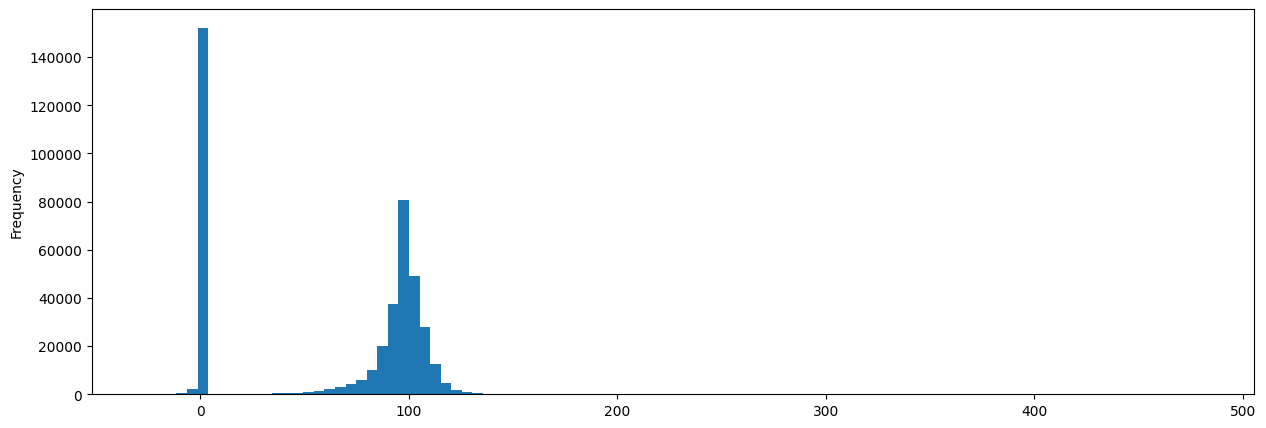

In [9]:
signals_cleaned_features.theoretical_performance_ratio.plot.hist(bins=100, figsize=(15, 5))

In [10]:
# Now lets select the variables we want to use for our model
print('Components:', list(failures.Component.unique()))

# We will use the following variables for our model
# Note that we are using the average temperature of each component
targets = {
    'GENERATOR': ['Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg','Gen_SlipRing_Temp_Avg',],
    'HYDRAULIC_GROUP': ['Hyd_Oil_Temp_Avg'],
    'GENERATOR_BEARING': ['Gen_Bear_Temp_Avg','Gen_Bear2_Temp_Avg'],
    'TRANSFORMER': ['HVTrafo_Phase1_Temp_Avg','HVTrafo_Phase2_Temp_Avg','HVTrafo_Phase3_Temp_Avg'],
    'GEARBOX': ['Gear_Oil_Temp_Avg', 'Gear_Bear_Temp_Avg']
    }

Components: ['GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING', 'TRANSFORMER', 'GEARBOX']


In [11]:
# Train and test creation

for id in signals_cleaned_features.Turbine_ID.unique():
    print('Turbine ID: ', id)

    aux = signals_cleaned_features[signals_cleaned_features.Turbine_ID == id].drop(['Turbine_ID'], axis=1)
    print('Size of the dataset: ', aux.shape[0])

    # Creating test dataset
    test = aux['2017-06-01':]
    test.to_parquet(f'../data/processed/{int(id)}/test.parquet')

    # Filter alarm dates
    logs = load_logs()
    logs = logs[(logs.TimeReset.notna())&(logs.UnitTitle == id)].reset_index(drop=True)
    logs['TimeDetected'] = logs['TimeDetected'].apply(lambda x: (x - pd.Timedelta(hours=6)).strftime('%Y-%m-%d %H:%M:%S'))
    logs['TimeReset'] = logs['TimeReset'].apply(lambda x: (x + pd.Timedelta(hours=6)).strftime('%Y-%m-%d %H:%M:%S'))

    for x, y in logs[['TimeDetected', 'TimeReset']].values:
        aux = aux[(aux.index < x) | (aux.index > y)]

    print('Size of the dataset after filtering alarm dates: ', aux.shape[0])

    # Filter low/high wind speed
    aux = aux[(aux.Amb_WindSpeed_Avg >= 4) & (aux.Amb_WindSpeed_Avg <= 25)]

    print('Size of the dataset after filtering low/high wind speed: ', aux.shape[0])

    # Filter low/high theoretical performance ratio
    aux = aux[(aux.theoretical_performance_ratio >= 50) & (aux.theoretical_performance_ratio <= 150)]

    print('Size of the dataset after filtering low/high theoretical performance ratio: ', aux.shape[0])

    # Filter dates
    aux = aux[:'2017-06-01']

    print('Size of the dataset after filtering dates: ', aux.shape[0])
    print('\n')
    

    # Save dataset
    aux.to_parquet(f'../data/processed/{int(id)}/train.parquet')

Turbine ID:  1.0
Size of the dataset:  105264
Size of the dataset after filtering alarm dates:  88457
Size of the dataset after filtering low/high wind speed:  55479
Size of the dataset after filtering low/high theoretical performance ratio:  54867
Size of the dataset after filtering dates:  39388


Turbine ID:  6.0
Size of the dataset:  105264
Size of the dataset after filtering alarm dates:  90430
Size of the dataset after filtering low/high wind speed:  57054
Size of the dataset after filtering low/high theoretical performance ratio:  56097
Size of the dataset after filtering dates:  39680


Turbine ID:  7.0
Size of the dataset:  105264
Size of the dataset after filtering alarm dates:  90098
Size of the dataset after filtering low/high wind speed:  58509
Size of the dataset after filtering low/high theoretical performance ratio:  57821
Size of the dataset after filtering dates:  41226


Turbine ID:  11.0
Size of the dataset:  105264
Size of the dataset after filtering alarm dates:  